In [1]:
import requests
from bs4 import BeautifulSoup
import lxml
import re

import pandas as pd
pd.set_option('display.float_format', lambda x: '%0.4f' % x)
import numpy as np
np.set_printoptions(suppress=True)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import datetime
import pytz

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import legend
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px

/kaggle/input/mashina-kg-10k-advs/Mashina_kg_10k.csv


# Scrapping 10k urls with advertisements from Mashina.kg

In [2]:
# sub_url = []
# for i in range(1, 501):
#   url = 'https://www.mashina.kg/search/all/?page='+str(i)
#   response = requests.get(url)
#   soup = BeautifulSoup(response.text, "lxml")

#   objects = soup.find("div", class_='search-results-table')

#   links = objects.find_all('div', class_ = 'list-item')
#   for i in links:
#     sub_url.append(i.find('a')['href'])

# urls = []
# for i in sub_url:
#   urls.append('https://www.mashina.kg' + i)
# print(len(urls))
# urls[:5]

In [3]:
# tz = pytz.timezone('Asia/Bishkek')
# today = str(datetime.datetime.now(tz))

# count = 1

# mashina_info = []
# for url in urls:
#   resp = requests.get(url)
#   soup = BeautifulSoup(resp.text, "lxml")

#   atr_dict = {}

#   #to find a brand and model
#   try:
#     atr_dict['brand'] = soup.find('div', class_='breadcrumbs details-breadcrumb').find_all('a')[2].text
#   except:
#     pass
#   try:
#     atr_dict['model'] = soup.find('div', class_='breadcrumbs details-breadcrumb').find_all('a')[3].text
#   except:
#     pass

#   #to find a location
#   try:
#     atr_dict['location'] = soup.find('div', class_ = 'subblock location').find('a').text
#   except:
#     pass

#   #to find views and likes
#   try:
#     atr_dict['views'] = int(soup.find('span', class_ = 'listing-icons views').text)
#     atr_dict['likes'] = int(soup.find('span', class_ = 'listing-icons heart').text)
#   except:
#     pass

#   #to find when the adv was added
#   try:
#     atr_dict['adv_added'] = adv_added = soup.find('span', text = re.compile('Добавлено ')).text.strip().replace('Добавлено ', '')
#   except:
#     pass

#   #then let's add 'now' from datetime (we aready importet it)
#   atr_dict['today'] = today

#     #to find a price in USD and KGS
#   try:
#     atr_dict['usd_price'] = int(soup.find('div', class_='sep main').find('div', class_='price-dollar').text.replace('$ ', '').replace(' ', ''))
#   except:
#     pass
#   try:
#     atr_dict['price_kgs'] = int(soup.find('div', class_='sep main').find('div', class_='price-som').text.replace(' сом', '').replace(' ', ''))
#   except:
#     pass

#   # to find atributes
#   try:
#     atributes = soup.find_all('div', class_="field-row clr")
#     for atr in atributes:
#       key = atr.find('div', class_='field-label').text
#       value = atr.find('div', class_='field-value').text.strip()
#       atr_dict[key] = value
#   except:
#     pass

#   # to find description
#   try:
#     atr_dict['description'] = soup.find('div', class_='seller-comments').find('h2', class_='comment').text
#   except:
#     pass

#   # to find configuration
#   try:
#     configs = soup.find('div', class_='configuration').find_all('p')
#     for item in configs:
#       try:
#         atr_dict[item.text] = 1
#       except:
#         pass
#   except:
#     pass

#   mashina_info.append(atr_dict)
#   print(f'The adv #{count} scrapped ({len(atr_dict)} parameters). There are {len(urls) - count} ads left')
#   count +=1
# df = pd.DataFrame(mashina_info)
# df.to_csv('Mashina_kg_10k.csv', index = False, encoding='utf-8')

# Import and clean

In [4]:
# So, I created dataset and saved it as a csv file. Let's import it, read and clean

df = pd.read_csv('/kaggle/input/mashina-kg-10k-advs/Mashina_kg_10k.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 71 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   brand                            10000 non-null  object 
 1   model                            10000 non-null  object 
 2   location                         9950 non-null   object 
 3   views                            9950 non-null   float64
 4   likes                            7622 non-null   float64
 5   adv_added                        9950 non-null   object 
 6   today                            10000 non-null  object 
 7   usd_price                        9950 non-null   float64
 8   price_kgs                        9950 non-null   float64
 9   Год выпуска                      9950 non-null   object 
 10  Пробег                           9585 non-null   object 
 11  Кузов                            9950 non-null   object 
 12  Цвет               

In [6]:
# Let's drop uneccessary columns and rows with missed USD-prise and some uneccessary columns.
# Also I will drop KGS-price as it fully correlated with USD-price

# to drop uneccessary columns
df.drop(['price_kgs', '\nСообщение *\n', '\nВаше имя *\n', 'VIN', 'Рассрочка', 'Unnamed: 70'], axis = 1, inplace = True)

# to drop rows with empty price
df.dropna(subset=['usd_price'], axis = 0, inplace = True)

### location

In [7]:
# I will aggregate all cities/villages to regions because they are very close to each other and don't influence on price

#Bishkek
oblast_dictionary = {'Бишкек':'Bishkek'}

#Chuy
locations_Chuy_key = ('Сокулук', 'Кант', 'Токмок', 'Кара-Балта', 'Кемин', 'Шопоков', 'Беловодское', 'Лебединовка', 'Каинды')
locations_Chuy_value = 'Chuy'
oblast_dictionary.update(dict.fromkeys(locations_Chuy_key, locations_Chuy_value))

#Talas
locations_Talas_key = ('Кызыл-Адыр', 'Талас', 'Бакай-Ата', 'Покровка')
locations_Talas_value = 'Talas'
oblast_dictionary.update(dict.fromkeys(locations_Talas_key, locations_Talas_value))

#Issyk-Kul
locations_Issyk_Kul_key = ('Каракол','Боконбаево', 'Тюп', 'Балыкчи', 'Теплоключенка')
locations_Issyk_Kul_value = 'Issyk-Kul'
oblast_dictionary.update(dict.fromkeys(locations_Issyk_Kul_key, locations_Issyk_Kul_value))

#Naryn
locations_Naryn_key = ('Кочкорка', 'Нарын', 'Ат-Баши', 'Чаек')
locations_Naryn_value = 'Naryn'
oblast_dictionary.update(dict.fromkeys(locations_Naryn_key, locations_Naryn_value))

#Djalalabad
locations_Djalalabad_key = ('Ала-Бука', 'Джалал-Абад', 'Ала-Бука', 'Шамалды-Сай', 'Таш-Кумыр', 'Кочкор-Ата', 'Майлуу-Суу',
                            'Сузак', 'Базар-Коргон', 'Маасы', 'Кербен', 'Токтогул',  'Кара-Куль', 'Каныш-Кыя', 'Кок-Джангак')
locations_Djalalabad_value = 'Djalalabad'
oblast_dictionary.update(dict.fromkeys(locations_Djalalabad_key, locations_Djalalabad_value))

#Osh
locations_Osh_key = ('Ош','Кара-Суу', 'Ноокат', 'Узген', 'Кара-Кульджа', 'Араван', 'Гульча', 'Дароот-Коргон')
locations_Osh_value = 'Osh'
oblast_dictionary.update(dict.fromkeys(locations_Osh_key, locations_Osh_value))

#Batken
locations_Batken_key = ('Кадамжай', 'Кызыл-Кия', 'Баткен', 'Айдаркен', 'Сулюкта', 'Раззаков')
locations_Batken_value = 'Batken'
oblast_dictionary.update(dict.fromkeys(locations_Batken_key, locations_Batken_value))


location_out_key = ('Европа', 'Казахстан', 'США', 'Грузия', 'ОАЭ', 'Германия')
location_out_value = 'out'
oblast_dictionary.update(dict.fromkeys(location_out_key, location_out_value))

df['location'] = df.location.map(oblast_dictionary)

df.drop(['Регион, город продажи', 'Учёт'], axis = 1, inplace = True)


### engine

In [8]:
# In order to clean the feature 'Двигатель'. I will create 3 new features ['engine_type', 'fuel_engine_capacity', 'electro_engine_capacity']

def engine_clean(engine):
  L = engine.split('/')
  if len(L) == 2:
    return L[1].strip()
  elif len(L) == 3:
    return L[2].strip()
  else:
    return L[3].strip()


df['engine_type'] = df['Двигатель'].map(engine_clean)

# we will create feature 'fuel_engine_capacity' for fuel engine cars and 'electro_engine_capacity' for electro-engine cars
df['fuel_engine_capacity'] = df['Двигатель'].map(lambda i: i.split('/')[0].strip(' л, \n') if
                    ('л.с' not in i.split('/')[0].strip(' л, \n')) &
                    ('кВт' not in i.split('/')[0].strip(' л, \n')) &
                    ('квт' not in i.split('/')[0].strip(' л, \n'))
                    else np.nan)
df['fuel_engine_capacity'] = df['fuel_engine_capacity'].astype(float)
df['fuel_engine_capacity'] = df['fuel_engine_capacity'].map(lambda i: i if i < 10 else np.nan)

df['electro_engine_capacity'] = df['Двигатель'].map(lambda i: i.split('/')[0].strip(' л, \n, л.с, .') if 'л.с' in i.split('/')[0].strip(' л, \n') else np.nan)
df['electro_engine_capacity'] = df['electro_engine_capacity'].astype(float)

# and than drop the 'Двигатель'
df.drop('Двигатель', axis = 1, inplace = True)


### adv_added

In [9]:
# convert the adv_added to hours (who knows, maybe we will see the difference between old advs and new advs...)
def adv_added_clean(dur):
  D = dur.split()
  if 'мин.' in D:
    return int(D[0])/60
  elif 'ч.' in D:
    return int(D[0])
  elif 'д.' in D:
    return int(D[0])*24
  elif 'мес.' in D:
    return int(D[0])*168
  elif 'мес.' in D:
    return int(D[0])*168*12


df['adv_added'] = df['adv_added'].map(adv_added_clean)

df.drop('today', axis = 1, inplace = True)

### mileage and year of manufacture

In [10]:
df['Пробег'].info()

<class 'pandas.core.series.Series'>
Index: 9950 entries, 0 to 9999
Series name: Пробег
Non-Null Count  Dtype 
--------------  ----- 
9585 non-null   object
dtypes: object(1)
memory usage: 155.5+ KB


In [11]:
def mileage_claen(x:str) -> int:
  if pd.notnull(x):
    return int(x.replace(' км', ''))
  else:
    return 0


df['mileage'] = df['Пробег'].map(mileage_claen)

df.drop('Пробег', axis = 1, inplace = True)

In [12]:
df['year'] = df['Год выпуска'].str.replace(', новый', '').astype(int)
df.drop('Год выпуска', axis = 1, inplace = True)

In [13]:
df.loc[df.mileage == 0].shape

(365, 64)

In [14]:
# lets fill zero values of mileage using the mean mileage of the same manufacture yaer cars

dict_mean_mileage = df.groupby('year').agg({'mileage':'mean'}, axis = 1).sort_values('year', ascending = False).to_dict(orient='series')
dict_mean_mileage

{'mileage': year
 2023      202.8639
 2022     6303.5325
 2021    24669.5314
 2020    44398.8757
 2019    83057.7115
 2018    99797.8139
 2017   116610.7368
 2016   124251.0431
 2015   141499.3297
 2014   143836.6190
 2013   147507.8433
 2012   158726.4459
 2011   154996.6541
 2010   168240.6148
 2009   179558.6506
 2008   176311.3750
 2007   199569.1661
 2006   182925.1161
 2005   204820.3117
 2004   212122.5833
 2003   221438.0000
 2002   226734.1734
 2001   244453.1182
 2000   254469.3589
 1999   238512.8231
 1998   211302.7922
 1997   224344.9355
 1996   223749.5976
 1995   235381.2821
 1994   249172.0875
 1993   223554.3696
 1992   234144.6119
 1991   237142.3684
 1990   276084.1765
 1989   245382.8125
 1988   287972.1333
 1987   210154.3333
 1986   271842.7500
 1985   195965.5000
 1984   199482.4000
 1983   176463.0000
 1982   160605.5000
 1981   286700.0000
 1978    47475.5000
 1976    97000.0000
 1973     6738.0000
 1965   165326.0000
 1963    25000.0000
 1960    77000.0000
 19

In [15]:
df['mean_mileage'] = df.year.map(dict_mean_mileage)

In [16]:
df.loc[df.mileage == 0, 'mileage'] = df.loc[df.mileage == 0].mean_mileage
# df.drop('mean_mileage', axis = 1, inplace = True)

### complectation

In [17]:
bin_col = ['обвес', 'тонировка', 'спойлер', 'кожа',
       'дерево', 'CD', 'DVD', 'MP3', 'USB', 'антиблокировочная система (ABS)',
       'антипробуксовочная система', 'система курсовой устойчивости',
       'подушки безопасности', 'парктроник', 'камера заднего вида',
       'полный электропакет', 'сигнализация', 'кондиционер', 'климат контроль',
       'круиз-контроль', 'подогрев передних сидений', 'подогрев всех сидений',
       'обогрев зеркал', 'пневмоподвеска', 'память сидений', 'память руля',
       'датчик дождя', 'датчик света', 'корректор фар', 'центральный замок',
       'литые диски', 'люк', 'бортовой компьютер', 'сабвуфер', 'биксенон',
       'омыватель фар', 'газобалонное оборудование', 'ксенон',
       'комбинированный', 'автозавод', 'велюр']

df[bin_col] = df[bin_col].fillna(0)

veights = [1/df[i].sum()*10000 for i in bin_col]   # to find the veight of each option
df[bin_col] = df[bin_col].mul(veights, axis = 1)  # to multilly veights to option values

df['complectation'] = df[bin_col].sum(axis = 1)   # to sum all veights

# let's drop uneccessary columns
df.drop(bin_col, axis = 1, inplace = True)

### some new features

In [18]:
df.brand.unique()

array(['Lexus', 'Kia', 'Toyota', 'Mercedes-Benz', 'Honda', 'Hyundai',
       'BMW', 'Volkswagen', 'Chevrolet', 'Subaru', 'Land Rover', 'Nissan',
       'ВАЗ (Lada)', 'Daewoo', 'Porsche', 'Ford', 'BYD', 'Buick',
       'SsangYong', 'Mazda', 'Audi', 'ГАЗ', 'Mitsubishi', 'Opel', 'Scion',
       'Jeep', 'Renault Samsung', 'DongFeng', 'Chrysler', 'Renault',
       'Peugeot', 'Dodge', 'Genesis', 'Москвич', 'Infiniti', 'Geely',
       'Tesla', 'Volvo', 'Changan', 'Weltmeister', 'MINI', 'Rover',
       'Hongqi', 'Chery', 'Haval', 'LiXiang', 'Huawei', 'EXEED',
       'Leapmotor ', 'Zeekr', 'Skoda', 'Suzuki', 'Jaguar', 'Daihatsu',
       'Citroen', 'Ravon', 'ShuangHuan', 'Hummer', 'Jetour', 'FAW',
       'Tank', 'ORA', 'Acura', 'Voyah', 'Lincoln', 'Cadillac', 'Isuzu',
       'УАЗ', 'Xpeng', 'Neta', 'Polestar', 'Skywell', 'GMC', 'GAC',
       'Roewe', 'Great Wall', 'Fiat'], dtype=object)

In [19]:
# The feature 'brand_country'

japan_brands = ['Lexus', 'Toyota', 'Honda', 'Subaru', 'Mazda', 'Nissan', 'Mitsubishi', 'Suzuki', 'Isuzu']
japan_value = 'japan'
germany_brands = ['BMW', 'Mercedes-Benz', 'Volkswagen', 'Audi', 'Opel']
germany_value = 'germany'
korea_brands = ['Kia', 'Hyundai']
korea_value = 'korea'
other_brands = ['Chevrolet', 'Land Rover', 'ВАЗ (Lada)', 'Daewoo', 'Porsche', 'Ford', 'BYD', 'Buick',  'SsangYong', 'ГАЗ', 'Scion',
                'Jeep', 'Renault Samsung', 'DongFeng', 'Chrysler', 'Renault', 'Peugeot', 'Dodge', 'Genesis', 'Москвич', 'Infiniti', 'Geely',
                'Tesla', 'Volvo', 'Changan', 'Weltmeister', 'MINI', 'Rover', 'Hongqi', 'Chery', 'Haval', 'LiXiang', 'Huawei', 'EXEED',
                'Leapmotor ', 'Zeekr', 'Skoda', 'Jaguar', 'Daihatsu', 'Citroen', 'Ravon', 'ShuangHuan', 'Hummer', 'Jetour', 'FAW',
                'Tank', 'ORA', 'Acura', 'Voyah', 'Lincoln', 'Cadillac', 'УАЗ', 'Xpeng', 'Neta', 'Polestar', 'Skywell', 'GMC', 'GAC', 'Roewe', 'Great Wall', 'Fiat']
other_value = 'other'

brand_country_dict = dict.fromkeys(japan_brands, japan_value)
brand_country_dict.update(dict.fromkeys(germany_brands, germany_value))
brand_country_dict.update(dict.fromkeys(korea_brands, korea_value))
brand_country_dict.update(dict.fromkeys(other_brands, other_value))

df['brand_country'] = df.brand.map(brand_country_dict)

# We are ready to look for insights, let's start!


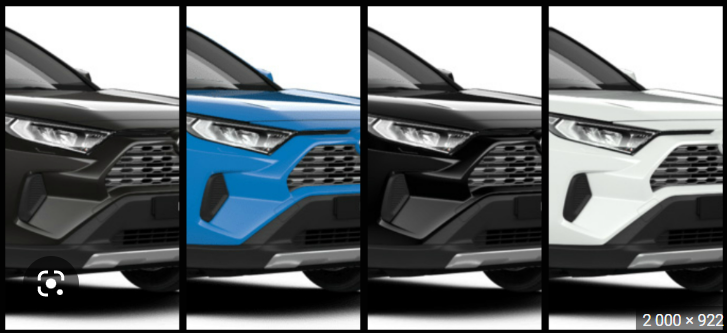

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9950 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   brand                    9950 non-null   object 
 1   model                    9950 non-null   object 
 2   location                 8951 non-null   object 
 3   views                    9950 non-null   float64
 4   likes                    7622 non-null   float64
 5   adv_added                9921 non-null   float64
 6   usd_price                9950 non-null   float64
 7   Кузов                    9950 non-null   object 
 8   Цвет                     9950 non-null   object 
 9   Коробка                  9950 non-null   object 
 10  Привод                   9950 non-null   object 
 11  Руль                     9950 non-null   object 
 12  Состояние                9950 non-null   object 
 13  Таможня                  8695 non-null   object 
 14  Обмен                    5606

In [21]:
df.columns

Index(['brand', 'model', 'location', 'views', 'likes', 'adv_added',
       'usd_price', 'Кузов', 'Цвет', 'Коробка', 'Привод', 'Руль', 'Состояние',
       'Таможня', 'Обмен', 'Наличие', 'Прочее', 'description', 'engine_type',
       'fuel_engine_capacity', 'electro_engine_capacity', 'mileage', 'year',
       'mean_mileage', 'complectation', 'brand_country'],
      dtype='object')

In [22]:
df = df[['brand', 'model', 'location', 'mileage', 'year', 'usd_price',
         'fuel_engine_capacity', 'electro_engine_capacity',
         'Кузов', 'Цвет', 'Коробка', 'Привод', 'Руль', 'Состояние',
         'Таможня', 'Обмен', 'Наличие', 'Прочее', 'description', 'engine_type',
         'complectation', 'views', 'likes', 'adv_added', 'mean_mileage', 'brand_country']]

### Price

<Axes: xlabel='usd_price', ylabel='Density'>

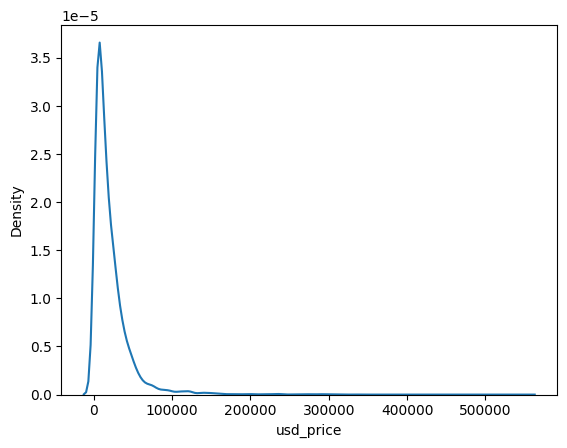

In [23]:
sns.kdeplot(df.usd_price)

Obviously, we have outlets that we need to get rid of

In [24]:
df.loc[(df.usd_price > 200000) & (df.year < (df.year.max() - 4))]

,brand,model,location,mileage,year,usd_price,fuel_engine_capacity,electro_engine_capacity,Кузов,Цвет,...,Наличие,Прочее,description,engine_type,complectation,views,likes,adv_added,mean_mileage,brand_country
555,Honda,Fit,Batken,221000,2004,530000.0000,1.3000,NaN,хэтчбек 5 дв.,белый,...,в наличии,NaN,Описание отсутствует,бензин,82.0342,38.0000,1.0000,1.0000,NaN,japan
892,Daewoo,Matiz,Djalalabad,145268,2003,280000.0000,1.0000,NaN,хэтчбек 5 дв.,красный,...,в наличии,NaN,не,бензин,19.8694,21.0000,NaN,4.0000,NaN,other
908,Daewoo,Matiz,Djalalabad,145268,2003,280000.0000,1.0000,NaN,хэтчбек 5 дв.,красный,...,в наличии,NaN,не,бензин,19.8694,22.0000,NaN,4.0000,NaN,other
1263,Honda,Stream,Bishkek,300000,2002,550000.0000,1.7000,NaN,компактвэн,серебристый,...,в наличии,NaN,Описание отсутствует,бензин,0.0000,27.0000,NaN,7.0000,NaN,japan
1280,Audi,A4,Osh,220000,2002,400000.0000,2.0000,NaN,седан,серый,...,в наличии,NaN,Описание отсутствует,бензин,16.0936,35.0000,NaN,8.0000,NaN,germany
1522,Mercedes-Benz,E-класс,Djalalabad,250000,1998,500000.0000,2.4000,NaN,седан,черный,...,в наличии,вложений не требует,\nОбмен только каролла и фит,бензин,19.2712,88.0000,1.0000,10.0000,NaN,germany


In [25]:
ind = df.loc[(df.usd_price > 200000) & (df.year < (df.year.max() - 4))].index
df.drop(ind, axis = 0, inplace=True)

<Axes: xlabel='usd_price', ylabel='Density'>

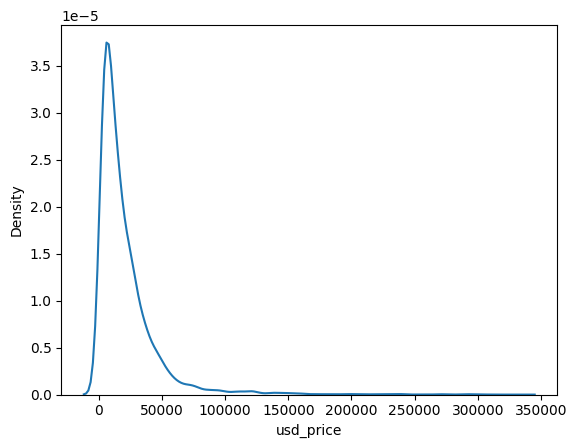

In [26]:
sns.kdeplot(df.usd_price)

In [27]:
df.loc[(df.usd_price > 200000)]

,brand,model,location,mileage,year,usd_price,fuel_engine_capacity,electro_engine_capacity,Кузов,Цвет,...,Наличие,Прочее,description,engine_type,complectation,views,likes,adv_added,mean_mileage,brand_country
200,BMW,X7,Bishkek,50,2022,215000.0000,4.4000,NaN,внедорожник 5 дв.,синий,...,в наличии,свежепригнан,"Новая, полная комплектация, w/u +12242849135",бензин,0.0000,1612.0000,4.0000,96.0000,NaN,germany
1194,Lexus,LX,Bishkek,NaN,2023,255000.0000,3.4000,NaN,внедорожник 5 дв.,белый,...,в наличии,"налог уплачен, вложений не требует",Абсолютно новый автомобиль(дилерский)\nЯпонска...,бензин,134.7977,1361.0000,4.0000,432.0000,NaN,japan
3809,Lexus,LX,Bishkek,NaN,2022,235000.0000,3.4000,NaN,внедорожник 5 дв.,серый,...,в наличии,NaN,Комплектация Вип Блэк машина без пробега !,бензин,0.0000,4736.0000,7.0000,504.0000,NaN,japan
3827,Mercedes-Benz,G-класс AMG,Bishkek,5,2023,333000.0000,4.0000,NaN,внедорожник 5 дв.,черный,...,в наличии,свежепригнан,Mercedes-Benz G63 AMG \n“Edition 55” в честь ю...,бензин,0.0000,1770.0000,4.0000,552.0000,NaN,germany
3829,Lexus,LX,Bishkek,NaN,2022,235000.0000,3.4000,NaN,внедорожник 5 дв.,черный,...,в наличии,NaN,"Новый автомобиль без пробега, комплектация VIP.",бензин,0.0000,3739.0000,4.0000,504.0000,NaN,japan
4690,BMW,X7,Bishkek,28,2023,225000.0000,4.4000,NaN,внедорожник 5 дв.,белый,...,в наличии,"свежепригнан, вложений не требует",🇰🇬 УЖЕ В КЫРГЫЗСТАНЕ 🇰🇬\n\nНОВЫЙ АВТОМОБИЛЬ\n\...,бензин,141.6970,1481.0000,6.0000,168.0000,NaN,germany
4707,Mercedes-Benz,G-класс AMG,NaN,NaN,2022,270000.0000,4.0000,NaN,внедорожник 5 дв.,черный,...,на заказ,NaN,"Автомобиль находится в городе Сеул, Корея!\n\n...",бензин,0.0000,3240.0000,2.0000,672.0000,NaN,germany
4708,Mercedes-Benz,G-класс AMG,NaN,10900,2021,240000.0000,4.0000,NaN,внедорожник 5 дв.,черный,...,в пути,NaN,"Mercedes - Benz G63 AMG\nАвто выкуплено, уже в...",бензин,0.0000,4221.0000,10.0000,840.0000,NaN,germany
5107,Lexus,LX,Bishkek,23,2022,255000.0000,3.4000,NaN,внедорожник 5 дв.,серый,...,в наличии,свежепригнан,Срочно! Представляем Вашему вниманию \nАвто лю...,бензин,162.0155,3831.0000,5.0000,600.0000,NaN,japan
5108,Lexus,LX,Bishkek,22,2022,205000.0000,3.4000,NaN,внедорожник 5 дв.,черный,...,в наличии,NaN,Срочно! Представляем Вашему вниманию \nАвто лю...,бензин,162.0155,4167.0000,4.0000,600.0000,NaN,japan


Now it looks like a true

In [28]:
fig = px.box(df[df['Таможня'] == 'растаможен'],  x="brand", y="usd_price", color="brand_country")
fig.update_traces(quartilemethod="exclusive")
fig.show()

### Mileage

In [29]:
fig = px.scatter(df, x='mileage', y='year', symbol = 'brand_country', color = 'brand_country')
fig.show()

There are doubts about new cars with high mileage and old cars with low mileage

In [30]:
df.loc[(df.year < 2010) & (df.mileage < 50000)]

,brand,model,location,mileage,year,usd_price,fuel_engine_capacity,electro_engine_capacity,Кузов,Цвет,...,Наличие,Прочее,description,engine_type,complectation,views,likes,adv_added,mean_mileage,brand_country
55,Nissan,Navara (Frontier),Chuy,25500,2008,15000.0000,2.5000,NaN,пикап двойная кабина,серебристый,...,в наличии,"налог уплачен, техосмотр пройден, вложений не ...",За срочности!\nNissan Navara: 2.5л/2008г./пика...,дизель,169.2723,1758.0000,5.0000,120.0000,NaN,japan
123,Toyota,Camry,Bishkek,27200,2004,8900.0000,2.4000,NaN,седан,серебристый,...,в наличии,NaN,"Американец 2.4 \nСрочно 8,900$ мини торг",бензин,0.0000,2824.0000,19.0000,72.0000,NaN,japan
244,Mercedes-Benz,E-класс,Bishkek,12000,2002,18999.0000,3.2000,NaN,седан,белый,...,в наличии,NaN,19$т.цена на сегодня до завтра!\n#Mercedes-Ben...,дизель,0.0000,1319.0000,11.0000,96.0000,NaN,germany
278,Subaru,Outback,Chuy,32500,2003,8500.0000,2.5000,NaN,универсал,серебристый,...,в наличии,NaN,Продаю Субару ГАЗ - БЕНЗИН 2003 год объем 3 К...,бензин,82.2735,531.0000,6.0000,192.0000,NaN,japan
295,Daewoo,Matiz,Djalalabad,15787,2005,2504.0000,0.8000,NaN,хэтчбек 5 дв.,голубой,...,в наличии,вложений не требует,Описание отсутствует,бензин,0.0000,22.0000,NaN,0.4833,NaN,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9888,Honda,Stepwgn,Bishkek,37000,2004,9300.0000,2.0000,NaN,минивэн,белый,...,в наличии,"налог уплачен, техосмотр пройден, вложений не ...","продаю хонда степвагон,под спада,2004год,2обем...",бензин,0.0000,261.0000,3.0000,264.0000,NaN,japan
9891,Mercedes-Benz,E-класс,Bishkek,45000,2000,7000.0000,2.7000,NaN,универсал,серебристый,...,в наличии,NaN,ватсап 0220 73 91 90\r\n\r\n,дизель,45.6255,485.0000,1.0000,432.0000,NaN,germany
9894,Honda,Fit,Djalalabad,25000,2007,6258.0000,1.3000,NaN,хэтчбек 5 дв.,белый,...,в наличии,NaN,Описание отсутствует,бензин,0.0000,1135.0000,7.0000,336.0000,NaN,japan
9903,Mercedes-Benz,E-класс,Bishkek,42000,1998,5800.0000,2.4000,NaN,седан,синий,...,в наличии,"налог уплачен, техосмотр пройден, вложений не ...","Ухоженный лупарь, вложение почти нет.Состояние...",бензин,60.3868,861.0000,6.0000,456.0000,NaN,germany


In [31]:
df.loc[df.mileage > 600000]

,brand,model,location,mileage,year,usd_price,fuel_engine_capacity,electro_engine_capacity,Кузов,Цвет,...,Наличие,Прочее,description,engine_type,complectation,views,likes,adv_added,mean_mileage,brand_country
634,Audi,100,Batken,888888,1988,150.0000,2.0000,NaN,седан,белый,...,в наличии,NaN,Описание отсутствует,бензин,17.0866,58.0000,NaN,2.0000,NaN,germany
1517,ВАЗ (Lada),2107,Djalalabad,640000,2007,1594.0000,1.6000,NaN,седан,зеленый,...,в наличии,NaN,Матизге алмашам,бензин,0.0000,1644.0000,4.0000,168.0000,NaN,other
1523,Daewoo,Matiz,Osh,619556,2007,4098.0000,0.8000,NaN,хэтчбек 5 дв.,зеленый,...,в наличии,NaN,И,бензин,0.0000,65.0000,NaN,10.0000,NaN,other
1526,Daewoo,Matiz,Osh,619556,2007,4098.0000,0.8000,NaN,хэтчбек 5 дв.,зеленый,...,в наличии,"вложений не требует, налог уплачен, техосмотр ...",Ш,бензин,0.0000,98.0000,NaN,11.0000,NaN,other
1896,Daewoo,Leganza,Djalalabad,860555,1997,2277.0000,1.8000,NaN,седан,белый,...,в наличии,вложений не требует,Описание отсутствует,бензин,35.6359,37.0000,NaN,11.0000,NaN,other
1921,Honda,Stream,Issyk-Kul,658245,2002,6850.0000,2.0000,NaN,компактвэн,серебристый,...,в наличии,NaN,"Хонда стрим, обем 2, хорошом состояние, цетр ...",бензин,0.0000,46.0000,1.0000,11.0000,NaN,japan
2354,Honda,Fit,Bishkek,900000,2002,4551.0000,1.5000,NaN,хэтчбек 5 дв.,серебристый,...,в наличии,NaN,Описание отсутствует,бензин,0.0000,71.0000,NaN,12.0000,NaN,japan
2484,BMW,5 серии,Chuy,848480,1991,1707.0000,2.0000,NaN,седан,вишня,...,в наличии,NaN,Описание отсутствует,бензин,0.0000,166.0000,3.0000,15.0000,NaN,germany
2731,ВАЗ (Lada),2107,Osh,842135,2012,2844.0000,1.6000,NaN,седан,белый,...,в наличии,NaN,Описание отсутствует,бензин,0.0000,133.0000,1.0000,13.0000,NaN,other
2920,Mercedes-Benz,E-класс,Bishkek,707070,1993,3413.0000,3.2000,NaN,седан,синий,...,в наличии,NaN,Реальным клиентам уступлю,бензин,27.0363,1512.0000,26.0000,360.0000,NaN,germany


All of them are wrong. I'will correct for mean mileage for the year

In [32]:
df.loc[(df.year <= 2013) & (df.mileage < 80000), 'mileage'] = df.loc[(df.year < 2010) & (df.mileage < 50000)].mean_mileage
df.loc[(df.year <= 2000) & (df.mileage < 120000), 'mileage'] = df.loc[(df.year <= 2000) & (df.mileage < 120000)].mean_mileage
df.loc[(df.year >= 2017) & (df.mileage > 400000), 'mileage'] = df.loc[(df.year >= 2017) & (df.mileage > 400000)].mean_mileage
df.loc[(df.mileage > 600000), 'mileage'] = df.loc[(df.mileage > 600000)].mean_mileage

In [33]:
fig = px.scatter(df, x='mileage', y='year', symbol = 'brand_country', color = 'brand_country')
fig.show()

In [34]:
df.loc[df.year < 1980]

,brand,model,location,mileage,year,usd_price,fuel_engine_capacity,electro_engine_capacity,Кузов,Цвет,...,Наличие,Прочее,description,engine_type,complectation,views,likes,adv_added,mean_mileage,brand_country
1152,ГАЗ,21 Волга,Osh,165326,1965,3415.0000,2.4000,NaN,седан,зеленый,...,в наличии,NaN,Описание отсутствует,бензин,0.0000,5236.0000,12.0000,1008.0000,NaN,other
1256,Москвич,403,Osh,NaN,1963,1138.0000,1.4000,NaN,седан,синий,...,в наличии,NaN,матор жасалган эканамичный бардыгы жакшы срочн...,бензин,0.0000,3201.0000,16.0000,672.0000,NaN,other
1357,ВАЗ (Lada),2101,Bishkek,NaN,1978,455.0000,1.2000,NaN,седан,бежевый,...,в наличии,NaN,Ваз 2101 на ходу коробка мотор мост кардан все...,бензин,0.0000,185.0000,1.0000,20.0000,NaN,other
2176,ГАЗ,69,Bishkek,NaN,1954,1707.0000,2.1000,NaN,внедорожник 3 дв.,зеленый,...,в наличии,NaN,Описание отсутствует,бензин,0.0000,70.0000,1.0000,11.0000,NaN,other
3163,ВАЗ (Lada),2101,Bishkek,NaN,1978,3500.0000,1.3000,NaN,седан,вишня,...,в наличии,"налог уплачен, техосмотр пройден",Описание отсутствует,бензин,2.8986,5379.0000,11.0000,840.0000,NaN,other
5592,ГАЗ,21 Волга,Bishkek,NaN,1963,10999.0000,2.4000,NaN,седан,белый,...,в наличии,NaN,Продаю волгу газ 21 в идеальном состоянии для ...,бензин,13.4278,4994.0000,14.0000,1512.0000,NaN,other
8686,ВАЗ (Lada),2103,Osh,NaN,1973,910.0000,1.5000,NaN,седан,зеленый,...,в наличии,NaN,Описание отсутствует,бензин,0.0000,50.0000,NaN,24.0000,NaN,other
9356,ГАЗ,21 Волга,Bishkek,NaN,1960,10809.0000,2.4000,NaN,седан,бирюзовый,...,в наличии,"налог уплачен, техосмотр пройден, вложений не ...","ГАЗ 21 , 1960г.",бензин,0.0000,480.0000,NaN,456.0000,NaN,other
9479,ГАЗ,24 Волга,Bishkek,NaN,1976,3300.0000,2.4000,NaN,седан,бежевый,...,в наличии,NaN,ГАЗ 24\n1976 г.в. \nЦвет слоновая кость\nКарбю...,бензин,0.0000,949.0000,12.0000,168.0000,NaN,other


In [35]:
fig = px.scatter(df, x='mileage', y='usd_price', symbol = 'brand_country', color = 'brand_country')
fig.show()

In [36]:
df.loc[(df.mileage > 190000) & (df.usd_price > 79000)]

,brand,model,location,mileage,year,usd_price,fuel_engine_capacity,electro_engine_capacity,Кузов,Цвет,...,Наличие,Прочее,description,engine_type,complectation,views,likes,adv_added,mean_mileage,brand_country
47,Mercedes-Benz,Maybach S-класс,Bishkek,366000,2016,80000.0000,4.7000,NaN,седан,черный,...,в наличии,вложений не требует,Всё работает четко.На обмен 90000$,бензин,0.0000,401.0000,1.0000,10.0000,NaN,germany
7290,Ford,F-150,Bishkek,280000,2013,120000.0000,6.1000,NaN,пикап двойная кабина,черный,...,в наличии,NaN,"Форд-F150 - RAPTOR, комплектация ROUSH. Объем ...",бензин,142.9257,10936.0000,6.0000,1008.0000,NaN,other
7768,Lexus,LX,NaN,208002,2018,93000.0000,5.7000,NaN,внедорожник 5 дв.,серый,...,на заказ,NaN,LEXUS LX570!\r\n\r\n1 ВЛАДЕЛЕЦ!\r\n\r\nПТС: ОР...,бензин,91.8042,657.0000,NaN,336.0000,NaN,japan


Ford's price looks suspicious

In [37]:
df.loc[df.model == 'F-150']

,brand,model,location,mileage,year,usd_price,fuel_engine_capacity,electro_engine_capacity,Кузов,Цвет,...,Наличие,Прочее,description,engine_type,complectation,views,likes,adv_added,mean_mileage,brand_country
694,Ford,F-150,Bishkek,140000,2018,75000.0000,3.5000,NaN,пикап двойная кабина,черный,...,в наличии,NaN,"Raptor V6 3.5 bi-turbo 450лс, \r\n10-cт. АКПП ...",бензин,0.0000,1040.0000,7.0000,456.0000,NaN,other
2093,Ford,F-150,Bishkek,250000,2005,14500.0000,5.4000,NaN,пикап полуторная кабина,зеленый,...,в наличии,NaN,"Ford F150 датчик света, камера заднего вида, з...",бензин,0.0000,409.0000,3.0000,192.0000,NaN,other
3321,Ford,F-150,Bishkek,100000,2005,14000.0000,4.2000,NaN,пикап полуторная кабина,белый,...,в наличии,NaN,"Продам Форд ф150 triton, 5местный, 2005г, белы...",бензин,0.0000,3354.0000,13.0000,504.0000,NaN,other
3750,Ford,F-150,out,196339,2017,48000.0000,3.5000,NaN,пикап двойная кабина,красный,...,в пути,NaN,"Машина в пути, цена с таможней! Дата прибытия...",бензин,36.3169,2840.0000,9.0000,504.0000,NaN,other
6010,Ford,F-150,out,135989,2017,27500.0000,4.9000,NaN,пикап двойная кабина,черный,...,на заказ,NaN,📌 Предлагаем вам приобрести данный или любой д...,бензин,91.9456,126.0000,NaN,96.0000,NaN,other
6250,Ford,F-150,out,167371,2017,45700.0000,3.5000,NaN,пикап полуторная кабина,серый,...,на заказ,NaN,📌 Предлагаем вам приобрести данный или любой д...,бензин,95.5317,2541.0000,3.0000,1008.0000,NaN,other
6265,Ford,F-150,out,204386,2018,41000.0000,3.5000,NaN,пикап двойная кабина,красный,...,на заказ,NaN,📌 Предлагаем вам приобрести данный или любой д...,бензин,95.5317,3011.0000,3.0000,1176.0000,NaN,other
7290,Ford,F-150,Bishkek,280000,2013,120000.0000,6.1000,NaN,пикап двойная кабина,черный,...,в наличии,NaN,"Форд-F150 - RAPTOR, комплектация ROUSH. Объем ...",бензин,142.9257,10936.0000,6.0000,1008.0000,NaN,other
7861,Ford,F-150,NaN,29844,2019,92811.0000,3.5000,NaN,пикап двойная кабина,черный,...,на заказ,NaN,Компания Silk Road Auto осуществляет подбор и ...,бензин,0.0000,5893.0000,7.0000,1512.0000,NaN,other


I will reduce the price 3 times

In [38]:
df.loc[(df.model == 'F-150') & (df.usd_price == 120000), 'usd_price'] /= 3

# Model

In [39]:
df.drop(['Прочее', 'description', 'mean_mileage', 'adv_added'], axis = 1, inplace = True)

In [40]:
df.shape

(9944, 22)

In [41]:
df.fillna(0, inplace = True)
df.drop_duplicates(inplace = True, ignore_index=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   brand                    9944 non-null   object 
 1   model                    9944 non-null   object 
 2   location                 9944 non-null   object 
 3   mileage                  9944 non-null   int64  
 4   year                     9944 non-null   int64  
 5   usd_price                9944 non-null   float64
 6   fuel_engine_capacity     9944 non-null   float64
 7   electro_engine_capacity  9944 non-null   float64
 8   Кузов                    9944 non-null   object 
 9   Цвет                     9944 non-null   object 
 10  Коробка                  9944 non-null   object 
 11  Привод                   9944 non-null   object 
 12  Руль                     9944 non-null   object 
 13  Состояние                9944 non-null   object 
 14  Таможня                 

In [43]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.svm import SVC
from sklearn.svm import SVR

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

from mlxtend.regressor import StackingCVRegressor

In [44]:
df.describe()

,mileage,year,usd_price,fuel_engine_capacity,electro_engine_capacity,complectation,views,likes
count,9944.0000,9944.0000,9944.0000,9944.0000,9944.0000,9944.0000,9944.0000,9944.0000
mean,149863.6592,2010.0763,20877.7019,2.3475,6.1487,41.2151,1112.8491,4.7329
std,109544.5174,8.6231,25350.0356,1.0438,43.7013,45.1245,2368.2437,8.3493
min,0.0000,1954.0000,150.0000,0.0000,0.0000,0.0000,6.0000,0.0000
25%,60000.0000,2003.0000,6485.0000,1.8000,0.0000,0.0000,181.0000,1.0000
50%,143000.0000,2011.0000,13700.0000,2.2000,0.0000,27.8485,496.0000,2.0000
75%,222000.0000,2017.0000,26200.0000,2.8000,0.0000,74.0093,1213.0000,6.0000
max,600000.0000,2023.0000,333000.0000,6.3000,646.0000,181.1337,112479.0000,344.0000


In [45]:
X = df.drop(["usd_price"], axis=1)
y = df["usd_price"]

In [46]:
X_ohe = pd.get_dummies(X)
X_cb = X.copy()

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size = .2, random_state=42, shuffle=True)
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y, test_size = .2, random_state=42, shuffle=True)
kfold = KFold(n_splits=3, shuffle = True, random_state=42)

## Basiline CatBoostRegressor

In [48]:
cat_features = ['brand', 'model', 'location', 'Кузов', 'Цвет', 'Коробка', 'Привод', 'Руль', 'Состояние', 'Таможня',
                'Обмен', 'Наличие', 'engine_type','brand_country']

In [49]:
model = CatBoostRegressor(
    cat_features = cat_features,
    verbose = False,
    random_seed = 42
    )

score = cross_val_score(model, X_train_cb, y_train_cb, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold)
RMSE = np.sqrt(score.mean() * -1)
print('CatBoostRegressor mean RMSE: ', RMSE)

CatBoostRegressor mean RMSE:  7084.654700447111


In [50]:
model = CatBoostRegressor(
    cat_features = cat_features,
    verbose = False,
    random_seed = 42
    )

model.fit(X_train_cb, y_train_cb)
y_pred = model.predict(X_test_cb)
mean_squared_error(y_test_cb, y_pred) ** 0.5

7577.843017118324

In [51]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType

## Baseline models

In [52]:
# evaluate models
models = []
models.append(('Ridge Regression', Ridge(alpha=1.0)))
models.append(('ElasticNet', ElasticNet()))
models.append(('Lasso', Lasso(random_state=42)))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42)))
models.append(('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42)))
models.append(('XGBoost Regressor', XGBRegressor(objective='reg:squarederror', random_state=42)))
models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))


# set table to table to populate with performance results
rmse_results = []
names = []
col = ['Algorithm', 'RMSE Mean', 'RMSE SD']
df_results = pd.DataFrame(columns=col)

# evaluate each model using cross-validation

i = 0
for name, model in models:
    # -mse scoring
    cv_mse_results = cross_val_score(
        model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    # calculate and append rmse results
    cv_rmse_results = np.sqrt(-cv_mse_results)
    rmse_results.append(cv_rmse_results)
    names.append(name)
    df_results.loc[i] = [name,
                        round(cv_rmse_results.mean(), 4),
                        round(cv_rmse_results.std(), 4)]
    i += 1

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.548e+11, tolerance: 3.474e+08

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e+11, tolerance: 3.593e+08

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+11, tolerance: 3.001e+08



In [53]:
df_results.sort_values(by=['RMSE Mean'], ascending=True).reset_index(drop=True)

,Algorithm,RMSE Mean,RMSE SD
0,XGBoost Regressor,7132.5304,393.0169
1,Random Forest,7376.2459,468.5027
2,Gradient Boosting Regressor,8046.7428,427.4866
3,DecisionTreeRegressor,9894.4938,962.9965
4,Ridge Regression,12696.2104,969.9936
5,Lasso,12802.8778,827.5577
6,ElasticNet,17451.6878,1663.7117


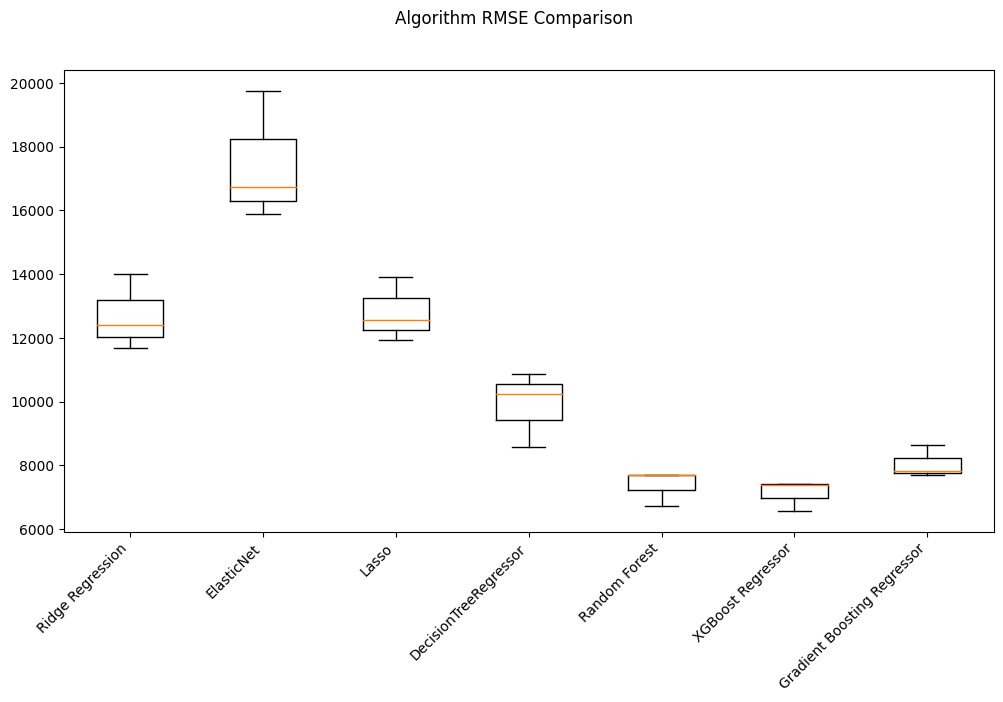

In [54]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle('Algorithm RMSE Comparison')
ax = fig.add_subplot(111)
plt.boxplot(rmse_results)
ax.set_xticklabels(names)
plt.xticks(rotation=45, ha='right')
plt.show();

## Tuning ML Hyper-Parameters

In [55]:
optuna_results = {}

### CatBoostRegressor

In [56]:
def objective(trial):
    model = CatBoostRegressor(
        iterations = trial.suggest_int("iterations", 30, 2000),
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log = True),
        depth =  trial.suggest_int("depth", 3, 10),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 2, 30),
        cat_features = cat_features,
        verbose = False,
        random_seed = 42
    )

    score = cross_val_score(model, X_train_cb, y_train_cb, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

# study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100, timeout=60*30)

# print params
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))

# save params
cboost_best_params = study.best_params
optuna_results['CatBoostRegressor'] = trial.value

Number of completed trials: 29
Best trial:
	Best Score: 6880.587573217883
	Best Params: 
		iterations = 1722,
		learning_rate = 0.05073499216730653,
		depth = 6,
		min_data_in_leaf = 15,


In [57]:
optuna.visualization.plot_optimization_history(study)

In [58]:
optuna.visualization.plot_param_importances(study)

### Ridge

In [59]:
# def objective(trial):

#     model = Ridge(
#         alpha=trial.suggest_float('alpha', 1e-3, 1e3, log = True),
# #         solver=trial.suggest_categorical('solver', ['auto','sag', 'saga']),
#         random_state=42)

#     score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold)
#     RMSE = (score.mean() * -1) ** 0.5
#     return RMSE

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_jobs=-1, n_trials=30)

# print("Number of completed trials: {}".format(len(study.trials)))
# print("Best trial:")
# trial = study.best_trial

# print("\tBest Score: {}".format(trial.value))
# print("\tBest Params: ")
# for key, value in trial.params.items():
#     print("\t\t{} = {},".format(key, value))


# ride_best_param = study.best_params
# optuna_results['Ridge'] = trial.value

### ElasticNet

In [60]:
# def objective(trial):

#     model = ElasticNet(
#         alpha=trial.suggest_float('alpha', 1e-5,1e3, log = True),
#         l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9, log = True),
#         random_state=42)

#     score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold)
#     RMSE = (score.mean() * -1) ** 0.5
#     return RMSE

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_jobs=-1, n_trials=30, timeout=60*30)

# print("Number of completed trials: {}".format(len(study.trials)))
# print("Best trial:")
# trial = study.best_trial

# print("\tBest Score: {}".format(trial.value))
# print("\tBest Params: ")
# for key, value in trial.params.items():
#     print("\t\t{} = {},".format(key, value))


# ElasticNet_best_param = study.best_params
# optuna_results['ElasticNet'] = trial.value

### Lasso

In [61]:
# def objective(trial):

#     model = Lasso(
#         alpha=trial.suggest_float('alpha', 1e-5,1e3, log = True),
#         random_state=42)

#     score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold)
#     RMSE = (score.mean() * -1) ** 0.5
#     return RMSE

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_jobs=-1, n_trials=30, timeout=60*30)

# print("Number of completed trials: {}".format(len(study.trials)))
# print("Best trial:")
# trial = study.best_trial

# print("\tBest Score: {}".format(trial.value))
# print("\tBest Params: ")
# for key, value in trial.params.items():
#     print("\t\t{} = {},".format(key, value))


# lasso_best_param = study.best_params
# optuna_results['Lasso'] = trial.value

### DecisionTreeRegressor

In [62]:
def objective(trial):

    model = DecisionTreeRegressor(
        criterion='squared_error',
        max_depth = trial.suggest_int('max_depth', 2, 50),
        min_samples_split = trial.suggest_int('min_samples_split', 2, 50),
        random_state=42,
    )

    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100, timeout=60*30)

print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))


DecisionTree_best_param = study.best_params
optuna_results['DecisionTree'] = trial.value

Number of completed trials: 100
Best trial:
	Best Score: 9146.263856229134
	Best Params: 
		max_depth = 24,
		min_samples_split = 29,


In [63]:
optuna.visualization.plot_optimization_history(study)

In [64]:
optuna.visualization.plot_param_importances(study)

In [65]:
optuna.visualization.plot_slice(study, params=['max_depth', 'min_samples_split'])

### RandomForestRegressor

In [66]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = .2, random_state=42, shuffle=True)

In [67]:
model = RandomForestRegressor(random_state=42)
model.fit(X_tr, y_tr)
y_pred = model.predict(X_val)
print(mean_squared_error(y_val, y_pred) ** 0.5)
model.get_params()

7350.577992477781


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [68]:
def objective(trial):

    model = RandomForestRegressor(
        max_depth = trial.suggest_int("max_depth", 2, 50),
        n_estimators = trial.suggest_int("n_estimators", 2, 2000),
        random_state=42,
    )

    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100, timeout=60*30)

print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))


RandomForest_best_param = study.best_params
optuna_results['RandomForest'] = trial.value

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Number of completed trials: 17
Best trial:
	Best Score: 7349.992667141947
	Best Params: 
		max_depth = 26,
		n_estimators = 246,


In [69]:
optuna.visualization.plot_optimization_history(study)

In [70]:
optuna.visualization.plot_param_importances(study)

### XGBRegressor

In [71]:
model = XGBRegressor(random_state=42)
model.fit(X_tr, y_tr)
y_pred = model.predict(X_val)
print(mean_squared_error(y_val, y_pred) ** 0.5)


7210.290905624344


In [72]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [73]:
def objective(trial):
    model = XGBRegressor(
        max_depth= trial.suggest_int('max_depth', 1, 16),
        learning_rate= trial.suggest_float('learning_rate', 1e-5,1e-1, log=True),
        n_estimators= trial.suggest_int('n_estimators', 50, 2000),
        random_state= 42
    )

    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

# study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100, timeout=60*30)

# print params
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))

# save params
xgbr_best_params = study.best_params
optuna_results['XGBRegressor'] = trial.value

Number of completed trials: 6
Best trial:
	Best Score: 6484.273082723341
	Best Params: 
		max_depth = 5,
		learning_rate = 0.09077881127208552,
		n_estimators = 753,


In [74]:
optuna.visualization.plot_optimization_history(study)

In [75]:
optuna.visualization.plot_param_importances(study)

### GradientBoostingRegressor

In [78]:
def objective(trial):
    model = GradientBoostingRegressor(
        n_estimators=trial.suggest_int('n_estimators', 10, 3000),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.15, log = True),
        max_depth=trial.suggest_int('max_depth', 2, 15),
        max_features=trial.suggest_int('max_features', 2, 6),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 3, 50),
        random_state=42)

    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

# study
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100, timeout=60*30)

# print params
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))

# save params
gbr_best_params = study.best_params
optuna_results['GradientBoostingRegressor'] = trial.value

Number of completed trials: 100
Best trial:
	Best Score: 7975.959018521654
	Best Params: 
		n_estimators = 2941,
		learning_rate = 0.05245837480997651,
		max_depth = 15,
		max_features = 6,
		min_samples_leaf = 4,


In [79]:
optuna.visualization.plot_optimization_history(study)

In [80]:
optuna.visualization.plot_param_importances(study)

## Comparison of results

In [81]:
pd.DataFrame.from_dict(optuna_results, orient='index', columns = ['Tuned RMSE'])

,Tuned RMSE
CatBoostRegressor,6880.5876
DecisionTree,9146.2639
RandomForest,7349.9927
XGBRegressor,6484.2731
GradientBoostingRegressor,7975.9590


## Fitting and checking

In [89]:
LR = LinearRegression()

CBR = CatBoostRegressor(
    iterations = 1722,
    learning_rate = 0.05073499216730653,
    depth = 6,
    min_data_in_leaf = 15,
    cat_features = cat_features,
    verbose = False,
    random_seed = 42
)

DTR = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth = 24,
    min_samples_split = 29,
    random_state=42
    )

RFR = RandomForestRegressor(
    max_depth = 26,
    n_estimators = 246,
    random_state=42
    )

XGBR = XGBRegressor(
    max_depth = 5,
    learning_rate = 0.09077881127208552,
    n_estimators = 753,
    random_state= 42
    )

GBR = GradientBoostingRegressor(
    n_estimators = 2941,
    learning_rate = 0.05245837480997651,
    max_depth = 15,
    max_features = 6,
    min_samples_leaf = 4,
    random_state=42
    )

In [90]:
models = [
    ('DecisionTree', DTR),
    ('Random Forest', RFR),
    ('XGBoost', XGBR),
    ('GradientBoosting', GBR),
    ]

In [91]:
results = {}
for name, model in models:
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    rmse = mean_squared_error(y_test, prediction, squared = False)
    results[name] = rmse

    print("-------{}-------".format(name))
    print("Root Mean Squared Error: {}".format(rmse))
    print("----------------------------------\n")

-------DecisionTree-------
Root Mean Squared Error: 10830.201023599442
----------------------------------

-------Random Forest-------
Root Mean Squared Error: 8901.26094679435
----------------------------------

-------XGBoost-------
Root Mean Squared Error: 8423.714047049816
----------------------------------

-------GradientBoosting-------
Root Mean Squared Error: 8106.810213467735
----------------------------------



### CatBoostRegressor result

In [104]:
CBR.fit(X_train_cb, y_train_cb)
CBR_prediction = CBR.predict(X_test_cb)

rmse = mean_squared_error(y_test_cb, CBR_prediction, squared = False)

print("-------{CatBoostRegressor}-------")
print(f"Root Mean Squared Error: {rmse}")
print("----------------------------------\n")

-------{CatBoostRegressor}-------
Root Mean Squared Error: 7470.9847343324
----------------------------------



In [99]:
results['CatBoostRegressor'] = rmse

### StackingRegressor result

In [94]:
# StackingRegressor

base_models = [
    ('DecisionTree', DTR),
    ('Random Forest', RFR),
    ('XGBoost', XGBR),
    ('GradientBoosting', GBR),
    ]

stacked = StackingRegressor(
    estimators = base_models,
    final_estimator = LinearRegression(),
    cv = 3)

In [95]:
stacked.fit(X_train, y_train)
stacked_prediction = stacked.predict(X_test)

stacked_rmse = mean_squared_error(y_test, stacked_prediction, squared = False)
results['Stacked'] = stacked_rmse

print("-------Stacked Ensemble-------")
print("Root Mean Squared Error: {}".format(stacked_rmse))
print("----------------------------------")

-------Stacked Ensemble-------
Root Mean Squared Error: 7768.987633968068
----------------------------------


In [103]:
results

{'DecisionTree': 10830.201023599442,
 'Random Forest': 8901.26094679435,
 'XGBoost': 8423.714047049816,
 'GradientBoosting': 8106.810213467735,
 'Stacked': 7768.987633968068,
 'CatBoostRegressor': 7470.9847343324}

CatBoostRegressor has the best rmse score

In [107]:
# CatBoostRegressor r2
print('r2 score:', r2_score(y_test_cb, CBR_prediction))

r2 score: 0.9179558285673


In [108]:
# StackedModelRegressor r2
print('r2 score:', r2_score(y_test, stacked_prediction))

r2 score: 0.911280130208517
